# Import

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [0]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [0]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import seaborn as sns
import sys
import time
import contextlib
import matplotlib.pyplot as plt
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Target Distributions

## Definitions

In [0]:
def w1(z1):
  return tf.math.sin(2.*np.pi*z1/4.)

def w2(z1):
  return 3.*tf.exp(-.5*(((z1-1.)/.6))**2)

@tf.function
def target_prob1(z):
  z1, z2 = z[:, 0], z[:, 1]
  norm = tf.sqrt(z1**2+z2**2)
  exp1 = tf.exp(-0.5*((z1-2)/0.6)**2)
  exp2 = tf.exp(-0.5*((z1+2)/0.6)**2)
  energy = 0.5*((norm - 2)/0.4)**2 - tf.math.log(exp1 + exp2)
  p = tf.exp(-energy) # not normalized yet
  return p

@tf.function
def target_prob2(z):
  z1, z2 = z[:, 0], z[:, 1]
  exp1 = tf.exp(-.5*((z2-w1(z1))/.35)**2)
  exp2 = tf.exp(-.5*((z2-w1(z1)+w2(z1))/.35)**2)
  exp3 = .1*tf.math.abs(z1)
  # energy = -tf.math.log(exp1+exp2+exp3)
  p = exp1+exp2+exp3 # not normalized yet
  return p

## Plots

In [0]:
def make_grids_for_plot(min_xy=-5., max_xy=5, n_grids=51):
  v = np.linspace(min_xy, max_xy, n_grids)
  x, y = np.meshgrid(v, v)
  z = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
  return x,y,z

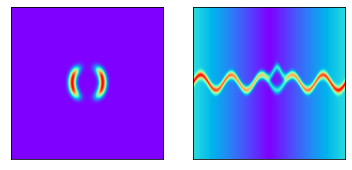

In [0]:
size = 1001
_,_,z = make_grids_for_plot(min_xy=-10., max_xy=10., n_grids=size)
z = tf.cast(z, tf.float32)

for i,prob in enumerate([target_prob1, target_prob2]):
  p = prob(z).numpy().reshape(size,size)
  plt.subplot(1,2,i+1)
  plt.imshow(p,cmap='rainbow')
  plt.xticks([])
  plt.yticks([])

# Model

## Base Distribution

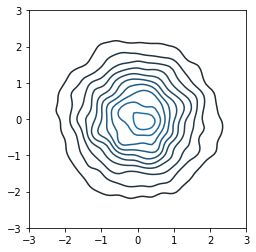

In [0]:
base_distribution = tfd.MultivariateNormalDiag(loc=0., scale_diag=[1., 1.])
samples = base_distribution.sample(10000).numpy()

plt.axes(aspect='equal', xlim=(-3,3), ylim=(-3,3))
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

## MLP

In [0]:
NUM_HIDDEN_UNITS = 128
NUM_HIDDEN_LAYERS = 2
DIM_INPUTS = 2 # dim_output must be equal to dim_input in time_derivative_fn of ODE 

class MLP_ODE(tfk.Model):
  def __init__(self):
    super(MLP_ODE, self).__init__()
    self._hidden_layers = [tfkl.Dense(NUM_HIDDEN_UNITS, 'tanh') for _ in range(NUM_HIDDEN_LAYERS)]
    self._gates = tfkl.Dense(NUM_HIDDEN_UNITS, 'sigmoid')
    self._top_layer = tfkl.Dense(DIM_INPUTS)
  
  @tf.function
  def call(self, t, inputs):
    t = tf.broadcast_to(t, inputs.shape)
    x = inputs
    for l in self._hidden_layers: x = l(x)
    g = self._gates(t)
    return self._top_layer(g*x)

## Bijector

In [0]:
class ContinuousNormalizingFlow(tfb.Bijector):

  def __init__(self,
               base_distribution=base_distribution,
               num_stacked_ffjords=3,
               atol=1e-3):
    super(ContinuousNormalizingFlow, self).__init__(forward_min_event_ndims=0)    
    
    # Make a chain of bijectors
    solver = tfp.math.ode.DormandPrince(atol=atol)
    trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
    bijectors = []

    for _ in range(num_stacked_ffjords):
      next_ffjord = tfb.FFJORD(
          state_time_derivative_fn=MLP_ODE(),
          ode_solve_fn=solver.solve,
          trace_augmentation_fn=trace_augmentation_fn)
      bijectors.append(next_ffjord)

    # tfb.Chain takes a list of bijectors in the reverse order where they are applied
    self._stacked_ffjord = tfb.Chain(bijectors[::-1])
    
    # Make transformed dist.
    self._base_distribution = base_distribution
    self._transformed_distribution = tfd.TransformedDistribution(
        distribution=self._base_distribution,
        bijector=self._stacked_ffjord)
  

  def _forward(self, x):
    return self._stacked_ffjord.forward(x)


  def _inverse(self, y):
    return self._stacked_ffjord.inverse(y)


  def _inverse_log_det_jacobian(self, y):
    return self._stacked_ffjord.inverse_log_det_jacobian(y)


  def _forward_log_det_jacobian(self, x):
    return self._stacked_ffjord.forward_log_det_jacobian(x)


  def log_prob(self, x):
    return self._transformed_distribution.log_prob(x)


  def sample_from_transformed_dist(self, sample_size):
    return self._transformed_distribution.sample(sample_size)
  

  def sample_from_base_dist(self, sample_size):
    return self._base_distribution.sample(sample_size)

# Train

## Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Trainer

In [0]:
FULL_BATCH_SIZE = 256

class Trainer():

  def __init__(self, cnf, prob_calculator):
    self.cnf = cnf
    self.prob_calculator = prob_calculator
  

  @tf.function
  def _train_step(self, x, optimizer):
    with tf.GradientTape() as tape:
      y = self.cnf.forward(x)
      log_p = tf.math.log(self.prob_calculator(y))
      log_q = self.cnf.log_prob(y)
      loss = tf.reduce_mean(log_q-log_p) # KL divergence
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss
  

  def train(self, num_epochs, optimizer, sample_size=FULL_BATCH_SIZE):
    losses = []
    for epoch in range(num_epochs):
      X = tf.cast(self.cnf.sample_from_base_dist(sample_size), tf.float32)
      loss = self._train_step(X, optimizer).numpy()
      losses.append(loss)
      sys.stdout.write('Epoch {0} ({1:.1f}%): Loss = {2:.5f}'\
                       .format(epoch+1, 100.*(epoch+1.)/num_epochs, loss))
    return losses

## Optmization

In [0]:
trainer1 = Trainer(ContinuousNormalizingFlow(atol=1e-5, num_stacked_ffjords=1), target_prob1)
# trainer2 = Trainer(ContinuousNormalizingFlow(atol=1e-5, num_stacked_ffjords=1), target_prob2)

In [0]:
LR = 1e-3

lst_epochs = [2000,]
lst_name = ['TrgtProb1',]
lst_trainer = [trainer1,]
lst_loss = []

for n_epochs, name, trainer in zip(lst_epochs, lst_name, lst_trainer):
  
  print('\n{}'.format(name))
  optimizer = tfk.optimizers.Adam(LR)
  
  with measure_time(), overwriting_stdout():
    l = trainer.train(n_epochs, optimizer)
  
  lst_loss.append(l)


TrgtProb1
Epoch 2000 (100.0%): Loss = -1.93296
Elapsed Time 847.206260 [sec]


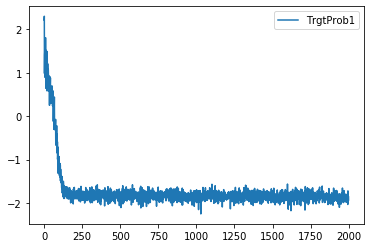

In [0]:
for name, loss in zip(lst_name, lst_loss):
  plt.plot(loss, label=name)
plt.legend()

# Results

## Scatter Plots

In [0]:
def get_samples(cnf, sample_size):
  base_distribution_samples = cnf.sample_from_base_dist(sample_size)
  transformed_samples = cnf.sample_from_transformed_dist(sample_size)
  return base_distribution_samples.numpy(), transformed_samples.numpy()

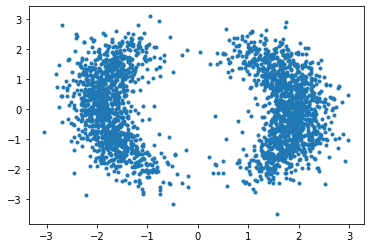

In [0]:
trainer = trainer1
_, x = get_samples(trainer.cnf, 2500)
plt.scatter(x[:,0],x[:,1],marker='.')
plt.show()

## KDE Plots

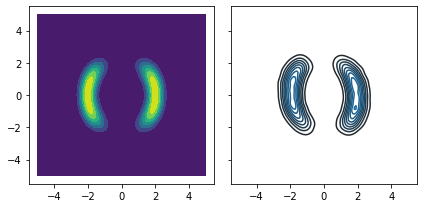

In [0]:
size = 501
max_ = 5.
min_ = -5.
x, y, z = make_grids_for_plot(min_,max_,size)
grids = tf.cast(z, tf.float32)

target = trainer1.prob_calculator
cnf = trainer1.cnf


# Plot figuress
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=[6,3])

# Target Dist.
p = target(grids).numpy().reshape(size,size)
axes[0].contourf(x, y, p)

# Dist. made with continuous normalizing flow
_, p = get_samples(cnf, 40000)
sns.kdeplot(p[:,0],p[:,1],ax=axes[1])

plt.tight_layout()

# References

1. https://arxiv.org/abs/1806.07366
1. https://arxiv.org/abs/1810.01367
1. https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/FFJORD_Demo.ipynb